<a href="https://colab.research.google.com/github/franciscofcs/Indicadores_Desempenho_Alunos/blob/master/XAI_em_modelos_de_ML_na_MDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Pipeline de Preprocessamento - Dados de Alunos do IFMA

This post will use a classic regression example — predicting house prices to demonstrate 4 practical steps in using Pipeline, which are how to:

<ol>
<li>Structure a workflow systematically before writing any pipeline code</li>
<li>Create custom transformers in Pipeline</li>
<li>Apply modular approach when building pipeline</li>
<li>Use same pipeline with different models to evaluate models’ performance quickly</li>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [3]:
!pip install feature_engine

In [4]:
import pandas as pd
import numpy as np

import missingno as msno

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
# from feature_engine import encoding

# ampliando as funcionalidades
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import plot_roc_curve

## Conhecendo os dados de alunos do IFMA

In [5]:
# dataset url
# 'https://www.kaggle.com/c/house-prices-advanced-regression-techniques'

# train = pd.read_csv('./drive/MyDrive/DOUTORADO UFMA/ESTUDO DIRIGIDO I/data/exemplos/house-prices-advanced-regression-techniques/train.csv', index_col ='Id')
# test = pd.read_csv('./drive/MyDrive/DOUTORADO UFMA/ESTUDO DIRIGIDO I/data/exemplos/house-prices-advanced-regression-techniques/test.csv', index_col ='Id')

df = pd.read_csv("./drive/MyDrive/DOUTORADO UFMA/ESTUDO DIRIGIDO I/data/suap/23062022/dados_caracterizacaosocial.csv")

# train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv", index_col ='Id')
# test = pd.read_csv("house-prices-advanced-regression-techniques/test.csv", index_col ='Id')

# X = train.drop('SalePrice', axis = 1)
# y = train['SalePrice']

In [6]:
# print(df.info())
# df.shape

In [7]:
# Transformando a variável-alvo
query = ['Concluído','Formado']
formados = df[df['situacao'].isin(query)]
formados.replace(['Concluído','Formado'], 1, inplace=True) # 1 - formado

query = ['Evasão','Cancelado','Cancelamento Compulsório','Jubilado','Transferido Externo']
evadidos = df[df['situacao'].isin(query)]

evadidos.replace(['Evasão','Cancelado','Cancelamento Compulsório','Jubilado','Transferido Externo'], 0, inplace=True) # 0 - evadido

df = pd.concat([formados, evadidos])
df.situacao.value_counts()

<ipython-input-7-cf8bada64839>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  formados.replace(['Concluído','Formado'], 1, inplace=True) # 1 - formado
<ipython-input-7-cf8bada64839>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evadidos.replace(['Evasão','Cancelado','Cancelamento Compulsório','Jubilado','Transferido Externo'], 0, inplace=True) # 0 - evadido


1    12895
0     5327
Name: situacao, dtype: int64

In [8]:
# print(df.info())
# df.shape

In [9]:
filtro1 = df['modalidade'] == 'Concomitante'  # 1,5 anos para conclusão
filtro2 = df['modalidade'] == 'Integrado'     # 3 anos para conclusão
filtro3 = df['modalidade'] == 'Integrado EJA' # 3 anos para conclusão
filtro4 = df['modalidade'] == 'Subsequente'   # 1,5 anos para conclusão

df = df[filtro1 | filtro2 | filtro3 | filtro4]
# print(df.info())
# df.shape

In [10]:
ano_conclusao = pd.to_datetime(df['dataconclusao'],errors='coerce')
df['ano_conclusao'] = ano_conclusao.dt.year

# Preenchendo dados ausentes com 0
# df['ano_conclusao'].fillna(df['ano_conclusao'].median(), inplace=True)
# df['ano_conclusao'] = df['ano_conclusao'].apply(int)

# Removendo linhas com ano de conclusão superior a 2022. (Foram removidas 3 linhas)
# df = dataset[df['ano_conclusao']<2023]

# Removendo coluna (s)
# df.drop('dataconclusao', axis=1, inplace=True)

### Criação da coluna 'pais_escolarizados'

Criação da coluna **'pais_escolarizados'**, a partir de 3 colunas do dataset: ***'companhia_domiciliar', 'mae_nivel_escolaridade', 'pai_nivel_escolaridade'***. O objetivo é verificar a relevância desta variável na predição da variável alvo.

In [11]:
### Criação da coluna 'pais_escolarizados'

# Criação da coluna **'pais_escolarizados'**, a partir de 3 colunas do df: ***'companhia_domiciliar', 'mae_nivel_escolaridade', 'pai_nivel_escolaridade'***. O objetivo é verificar a relevância desta variável na predição da variável alvo.

df["pais_escolarizados"] = 1 # escolarizado

mae = df.companhia_domiciliar == 'Mãe'
pai = df.companhia_domiciliar == 'Pai'
pais = df.companhia_domiciliar == 'Pais'
mae_escolaridade = df.mae_nivel_escolaridade == "Não Estudou"
pai_escolaridade = df.pai_nivel_escolaridade == "Não Estudou"
escola = df[(mae | pai | pais) & (mae_escolaridade & pai_escolaridade)]
escola.pais_escolarizados = 0 # não escolarizado

nao_informado_mae = df.mae_nivel_escolaridade == "Não sei informar"
nao_informado_pai = df.pai_nivel_escolaridade == "Não sei informar"
nao_conhece_pai = df.pai_nivel_escolaridade == "Não conhece"
nao_informado = df[nao_informado_mae | nao_informado_pai | nao_conhece_pai]
nao_informado.pais_escolarizados = 2 # não soube informar

df.pais_escolarizados.update(pd.Series(escola.pais_escolarizados, index = escola.pais_escolarizados.index.tolist()))
df.pais_escolarizados.update(pd.Series(nao_informado.pais_escolarizados, index = nao_informado.pais_escolarizados.index.tolist()))

<ipython-input-11-b74c4bb3da98>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  escola.pais_escolarizados = 0 # não escolarizado
<ipython-input-11-b74c4bb3da98>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nao_informado.pais_escolarizados = 2 # não soube informar


In [12]:
# print(df.info())
# df.shape

## Separaçãodo dataframe

In [13]:
# print(df.info())
# df.shape

In [14]:
# df['pais_escolarizados'].value_counts()

In [15]:
# df.isnull().sum().sort_values(ascending=False) * 100 / len(df)

In [16]:
# create train & validation set
# As colunas removidas por não se aplicarem ao contexto do dataset de treinamento
# 'situacao' é a classe-alvo
# as demais colunas ou são quase 100% nulas ou irrelevantes para predição ('ira' é um caso à parte, mas, excluída, no momento).
# X = df.drop(['alunoid','ira','pontuacao_seletivo','razao_ausencia_educacional','exclusivo_rede_publica','forma_acesso_seletivo','dataconclusao','situacao'], axis = 1).copy()

'''
colunas a serem removidas, por terem mais de 20% de nulos
pontuacao_seletivo            100.000000
razao_ausencia_educacional     99.051976
forma_acesso_seletivo          24.794484
dataconclusao                  22.440997
'''
X = df.drop(['alunoid','ira','pontuacao_seletivo','razao_ausencia_educacional','forma_acesso_seletivo','dataconclusao','exclusivo_rede_publica','situacao'], axis = 1).copy()

# X = df.drop(['alunoid','ira','exclusivo_rede_publica','situacao'], axis = 1).copy()
# X = df.drop(['alunoid','ira','pontuacao_seletivo','razao_ausencia_educacional','exclusivo_rede_publica','situacao'], axis = 1).copy()
# ['alunoid','ira','pontuacao_seletivo','razao_ausencia_educacional','exclusivo_rede_publica','situacao']
y = df['situacao']

# Gerando datasets de treino e teste
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)


In [17]:
# def tratando_X_trainXtest(X):
# recuperando as colunas com valores nulos
# colunas_com_nulos = [var for var in df.drop(['alunoid','ira','pontuacao_seletivo','razao_ausencia_educacional','exclusivo_rede_publica'], axis=1).columns if (df[var].isnull().any())]
colunas_com_nulos = [var for var in X.columns if (X[var].isnull().any())]

# Colunas numéricas com nulos
colunas_numericas_com_nulos = [var for var in colunas_com_nulos if (X[var].dtype=='int64') | (X[var].dtype=='float64')]

# Colunas categóricas com nulos
colunas_categoricas_com_nulos = [var for var in colunas_com_nulos if (X[var].dtype=='object') | (X[var].dtype=='bool')]

# verificando o tipo das colunas com valores nulos
# for coluna in colunas_com_nulos:
#   print('{}: {}'.format(coluna, df[coluna].dtype))

# ====================================================================================================================== #

## Selecting categorical and numeric features
# numerical_cols = X.select_dtypes(include=np.number).columns
# categories_cols = X.drop(['genero', 'raca', 'estado_civil'], axis=1).select_dtypes(exclude=np.number).columns

# list for numerical columns
numerical_cols = [var for var in X if (X[var].dtype=='int64') | (X[var].dtype=='float64')]
# numerical_cols = [var for var in df.drop(['alunoid','ira','pontuacao_seletivo','razao_ausencia_educacional','exclusivo_rede_publica','situacao'], axis=1) if (df[var].dtype=='int64') | (df[var].dtype=='float64')]

# list for one hot encoding columns
ohe_cols = ['genero', 'raca', 'estado_civil']
le_cols = [var for var in X.columns if (X[var].dtype=='object') | (X[var].dtype=='bool')]
# le_cols = [var for var in df.drop(['alunoid','ira','genero', 'raca', 'estado_civil','pontuacao_seletivo','razao_ausencia_educacional','exclusivo_rede_publica'], axis=1).columns if (df[var].dtype=='object') | (df[var].dtype=='bool')]

le_cols = list(set(le_cols) - set(ohe_cols))

# list for categorical columns
categories_cols = [var for var in X.columns if (X[var].dtype=='object') | (X[var].dtype=='bool')]

# return numerical_cols, categories_cols, ohe_cols, le_cols

In [18]:
# numerical_cols, categories_cols, ohe_cols, le_cols = tratando_dataset_trainXtest(X_train)

# print(len(numerical_cols),"=>",numerical_cols)
# print(len(categories_cols),"=>",categories_cols)
# print(len(ohe_cols),"=>",ohe_cols)
# print(len(le_cols),"=>",le_cols)

# numerical_cols, categories_cols, ohe_cols, le_cols = tratando_dataset_trainXtest(X_valid)

In [19]:
# X.shape

In [20]:
# y.value_counts()

In [21]:
# check pattern of missingness
# msno.matrix(X.iloc[:,:10])
# msno.matrix(X.iloc[:,10:])

In [22]:
# msno.bar(X)

In [23]:
# msno.heatmap(X)

In [24]:
import seaborn as sns
# import matplotlib.pyplot as plt

# g = sns.clustermap(X[numerical_cols].corr(),
#                    method = 'complete',
#                    cmap   = 'RdBu',
#                    annot  = True,
#                    annot_kws = {'size': 8})
# plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60);

## Step 1: Structure a workflow systematically before writing any pipeline code

In this experiments, the preprocessing steps are categorised into 3 following sections:-

<ol>
  <li> Filtering
    <ul>
      <li>Drop columns with more than 50% of missingness</li>
      <li>Select numerical / category features depending on the pipeline flow</li>
    </ul>
  </li>
  <li> Missingness Treatment
    <ul>
      <li>Median imputation for numerical features</li>
      <li>Most frequent imputation for categorical features</li>
    </ul>
  </li>
  <li> Feature Engineering
    <ul>
      <li>Create practical and predictive features using domain knowledge (e.g. adding all bathrooms). Full details check on this link.</li>
      <li>Encode all categorical features’ items with less than 20% frequency as 'rare'.</li>
      <li>One hot encoding all categories features at last step of preprocessing in categorical pipeline.</li>
    </ul>
  </li>
</ol>

## Step 2: Create custom transformers in pipeline

<b>These are 4 configurations that I always used when creating custom transformer</b>
<ul>
<li>Add <i>BaseEstimator</i> & <i>TransformerMixinto</i> inherit get_params and fit_transform function. Personally, I always use fit_transform when I need to have a quick view on the output.</li>
<li>Defineself.variablesattributes so that you can easily select which columns to be applied on later</li>
<li>Definefitmethod. Depending on the transformation, if it doesn’t require fitting, just create a dummy fit function.</li>
<li>Definetransformmethod. This is used to transform original dataset to modified dataset based on your transformation method.</li>

## Step 3: Apply modular approach when creating pipelines

### Custom transformers

Following step 1 & 2, we will create 6 custom transformers in order for the pipeline to work.

<ul>
  <li><strong>DropFeatureSelector</strong>: Drop columns based on names</li>
  <li><strong>FeatureSelector</strong>: Select columns based on names</li>
  <li><strong>SimpleImputerCustom</strong>: Improvise onsklearn.impute.SimpleImputer function so it returns as dataframe instead of np.array.</li>
  <li><strong>DomainNumFE</strong>: Feature engineering technique for numerical features based on domain knowledge</li>
  <li><strong>OneHotEncoderCustom</strong>: Improvise onsklearn.preprocessing.OneHotEncoder function so it returns as dataframe instead of np.array.</li>
  <li><strong>DomainCatFE</strong>: Feature engineering technique for categorical features based on domain knowledge</li>
</ul>

In [25]:
# from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, chi2
# from sklearn.svm import SVC

# create custom transformer
class DropFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        # self.imprime(X)
        X_dropped = X.drop(self.variables, axis = 1)
        # self.imprime(X_dropped)
        return X_dropped
    def imprime(self,X):
      print('drop feature')
      print(X.shape)

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X.loc[:,self.variables]

class SimpleImputerCustom(BaseEstimator, TransformerMixin):
    def __init__(self, variables, strategy):
        self.variables = variables
        self.strategy = strategy
        self.imp = SimpleImputer(missing_values=np.nan,
                    strategy=self.strategy)
    def fit(self, X, y = None):
        X_ = X.loc[:,self.variables]
        self.imp.fit(X_)
        return self
    def transform(self, X):
        X_ = X.loc[:,self.variables]
        # self.imprime(X_)
        X_transformed = pd.DataFrame(self.imp.transform(X_),
                         columns= self.variables)
        X.drop(self.variables, axis= 1, inplace=True)
        X[self.variables] = X_transformed[self.variables].values
        # self.imprime(X)
        return X

    def imprime(self,X):
      print('imputer')
      print(len(X))

class CreateColumnAnoConclusao(BaseEstimator, TransformerMixin):
    def __init__(self, variables = None):
        self.variables = variables
    def fit(self, X, y =None):
        return self
    def transform(self, X):
        # source: https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#Feature-Engineering

        ano_conclusao = pd.to_datetime(X['dataconclusao'],errors='coerce')
        X['ano_conclusao'] = ano_conclusao.dt.year

        # Preenchendo dados ausentes com 0
        X['ano_conclusao'].fillna(0, inplace=True)
        X['ano_conclusao'] = X['ano_conclusao'].apply(int)

        # Removendo linhas com ano de conclusão superior a 2022. (Foram removidas 3 linhas)
        # X = X[X['ano_conclusao']<2023]
        X = X[X['ano_conclusao']]

        # Removendo coluna (s)
        X.drop('dataconclusao', axis=1, inplace=True)

        return X

class ModificaRaca(BaseEstimator, TransformerMixin):
    def __init__(self, variables = None):
        self.variables = variables
    def fit(self, X, y =None):
        return self
    def transform(self, X):
        # source: https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#Feature-Engineering

        # Alterando valores da coluna 'raca'
        X.loc[X.raca == "branca","raca"]="Branca"
        X.loc[X.raca == "BRANCA","raca"]="Branca"
        X.loc[X.raca == "PARDA","raca"]="Parda"
        X.loc[X.raca == "parda","raca"]="Parda"
        X.loc[X.raca == "indígena","raca"]="Indigena"
        X.loc[X.raca == "INDIGENA","raca"]="Indigena"
        X.loc[X.raca == "Indígena","raca"]="Indigena"
        X.loc[X.raca == "PRETA","raca"]="Preta"
        X.loc[X.raca == "preta","raca"]="Preta"
        X.loc[X.raca == "AMARELA","raca"]="Amarela"
        X.loc[X.raca == "amarela","raca"]="Amarela"
        X.loc[X.raca == "NAO INFORMADO","raca"]="Não Informado"

        return X

class LabelEncoderCustom(BaseEstimator, TransformerMixin):
  def __init__(self, variables):
        self.variables = variables
  def fit(self, X, y=None):
   return self
  def transform(self, X ,y=None):
    le=LabelEncoder()
    for i in X[self.variables]:
      X[i]=le.fit_transform(X[i])
    # self.imprime(X)
    return X
  def imprime(self,X):
      print('label encoder')
      print(X.info())
      print(X.campus.value_counts())

class OneHotEncoderCustom(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        # self.ohe = OneHotEncoder(drop='first', handle_unknown = 'ignore')
        self.ohe = OneHotEncoder(handle_unknown = 'ignore')

    def fit(self, X, y = None):
        X_ = X.loc[:,self.variables]
        self.ohe.fit(X_)
        return self

    def transform(self, X):
        # self.imprime(X)
        X_ = X.loc[:,self.variables]
        # get one-hot encoded feature in df format
        X_transformed = pd.DataFrame(self.ohe.transform(X_).toarray(), columns= self.ohe.get_feature_names_out())

        # Remove columns that are one hot encoded in original df
        X.drop(self.variables, axis= 1, inplace=True)

        # Add one hot encoded feature to original df
        X[self.ohe.get_feature_names_out()] = X_transformed[self.ohe.get_feature_names_out()].values
        # print(X)
        # self.imprime(X)
        return X

    def get_feature_names_out(self):
      return self.ohe.get_feature_names_out()

    def imprime(self,X):
      print('one-hot encoder')
      # detalhes_dataset_tratado(X)

# OUTRA PROPOSTA DE CUSTOM PIPELINE PARA TRATAMENTO DE OUTILIERS
class OutlierReplace(BaseEstimator,TransformerMixin):
    def __init__(self,factor=2):
        self.factor = factor

    def outlier_detector(self,X,y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound.append(q1 - (self.factor * iqr))
        self.upper_bound.append(q3 + (self.factor * iqr))

    def fit(self,X,y=None):
        # self.imprime(X)
        self.lower_bound = []
        self.upper_bound = []
        X.apply(self.outlier_detector)
        return self

    def transform(self,X,y=None):

        X = pd.DataFrame(X).copy()
        for i in range(X.shape[1]):
            x = X.iloc[:, i].copy()
            mediana_coluna = x.median()
            x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = mediana_coluna
            X.iloc[:, i] = x
        # print(X)
        # self.imprime(X)
        return X

    # def imprime(self,X):
    #   print('outlier')
    #   print(X.shape)

class ClfSwitcher(BaseEstimator):
    def __init__(self, estimator = LogisticRegression()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

# ------------------------------------------------------------------------------- #
# Custom class to allow shape of transformed x to be known to classifier
class ANOVASelection(BaseEstimator, TransformerMixin):
    def __init__(self, percentile=10):
        self.percentile = percentile
        self.m = None
        self.X_new = None
        self.scores_ = None

    def fit(self, X, y):
        self.m = SelectPercentile(f_classif, self.percentile)
        self.m.fit(X,y)
        self.scores_ = self.m.scores_
        return self

    def transform(self, X):
        global X_new
        self.X_new = self.m.transform(X)
        X_new = self.X_new
        return self.X_new

# ------------------------------------------------------------------------------- #

# def atualiza_dataset(X):
#   # print(X)
#   X_ = X

# class OneHotEncodercustom(BaseEstimator, TransformerMixin):
#     def __init__(self, variables):
#         self.variables = variables
#         self.ohe = OneHotEncoder(drop='first',
#             handle_unknown = 'ignore')
#     def fit(self, X, y = None):
#         X_ = X.loc[:,self.variables]
#         self.ohe.fit(X_)
#         return self
#     def transform(self, X):
#         X_ = X.loc[:,self.variables]
#         X_transformed = pd.DataFrame(self.ohe.transform(X_).toarray(),
#             columns= self.ohe.get_feature_names_out())
#         X.drop(self.variables, axis= 1, inplace=True)
#         X[self.ohe.get_feature_names_out()] = X_transformed[self.ohe.get_feature_names_out()].values

#         return X

# ------------------------------------------------------------------------------------------------------

# class DomainCatFE(BaseEstimator, TransformerMixin):
#     def __init__(self, variables = None):
#         self.variables = variables
#     def fit(self, X, y =None):
#         return self
#     def transform(self, X):
#       # source: https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#Feature-Engineering
#       X_ = X.copy()
#       X_['BsmtFinType1_Unf'] = 1*(X_['BsmtFinType1'] == 'Unf')
#       X_['Total_Bathrooms'] = (X_['FullBath'] + (0.5 * X_['HalfBath'])
#           + X_['BsmtFullBath'] + (0.5 * X_['BsmtHalfBath']))
#       X_['GarageCars'] = X_['GarageCars'].apply(lambda x: 0
#           if x <= 0.0 else x)
#       X_['hasfireplace'] = X_['Fireplaces'].apply(lambda x: 1
#           if x > 0 else 0)
#       return X_

# ------------------------------------------------------------------------------------------------------

# class CourseSituationFilter(BaseEstimator, TransformerMixin):
#     def __init__(self, variables = None):
#         self.variables = variables
#     def fit(self, X, y =None):
#         return self
#     def transform(self, X):
#         # source: https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#Feature-Engineering

#         query = ['Concluído','Formado']
#         formados = X[X['situacao'].isin(query)]
#         formados.replace(['Concluído','Formado'], 1, inplace=True) # 1 - formado

#         query = ['Evasão','Cancelado','Cancelamento Compulsório','Jubilado','Transferido Externo']
#         evadidos = X[X['situacao'].isin(query)]

#         evadidos.replace(['Evasão','Cancelado','Cancelamento Compulsório','Jubilado','Transferido Externo'], 0, inplace=True) # 0 - evadido

#         X_ = pd.concat([formados, evadidos])

#         return X_

# ------------------------------------------------------------------------------------------------------

# class CourseModalityFilter(BaseEstimator, TransformerMixin):
#     def __init__(self, variables = None):
#         self.variables = variables
#     def fit(self, X, y =None):
#         return self
#     def transform(self, X):
#         # self.imprime(X)
#         # source: https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#Feature-Engineering

#         filtro1 = X['modalidade'] == 'Concomitante'  # 1,5 anos para conclusão
#         filtro2 = X['modalidade'] == 'Integrado'     # 3 anos para conclusão
#         filtro3 = X['modalidade'] == 'Integrado EJA' # 3 anos para conclusão
#         filtro4 = X['modalidade'] == 'Subsequente'   # 1,5 anos para conclusão

#         X_ = X[filtro1 | filtro2 | filtro3 | filtro4]
#         # self.imprime(X_)
#         return X_

#     def imprime(self,X):
#       print('modalidade')
#       print(X.shape)

# ------------------------------------------------------------------------------------------------------

# class OutlierRemover(BaseEstimator,TransformerMixin):
#     def __init__(self, factor=1.5):
#         self.factor = factor

#     def outliers_iqr(self, X, y=None):
#         X = pd.Series(X).copy()
#         q1 = X.quantile(0.25)
#         q3 = X.quantile(0.75)
#         iqr = q3 - q1
#         lower_bound = q1 - (iqr * self.factor)
#         upper_bound = q3 + (iqr * self.factor)
#         # filter only those rows that are greater than lower_bound and less than upper_bound,
#         #i.e. drop values outside the given interval
#         X.loc[((X >= lower_bound) & (X <= upper_bound))]

#         return pd.Series(X)

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return X.apply(self.outliers_iqr)

# ------------------------------------------------------------------------------------------------------

# class OutlierReplace(BaseEstimator,TransformerMixin):
#     def __init__(self,factor=1.5):
#         self.factor = factor

#     def outlier_removal(self,X,y=None):
#         X = pd.Series(X).copy()
#         print(X)
#         q1 = X.quantile(0.25)
#         q3 = X.quantile(0.75)
#         iqr = q3 - q1
#         lower_bound = q1 - (self.factor * iqr)
#         upper_bound = q3 + (self.factor * iqr)

#         mediana_coluna = X.median()
#         X.loc[((X < lower_bound) | (X > upper_bound))] = mediana_coluna
#         return pd.Series(X)

#     def fit(self,X,y=None):
#         return self

#     def transform(self,X,y=None):
#         self.imprime(X)
#         return X.apply(self.outlier_removal)

#     def imprime(self,X):
#       print('outlier')
#       print(X.shape)

# ------------------------------------------------------------------------------------------------------

# class RemoveIQROutliers(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return X.loc[X != 'OUTLIER']

### Identificando colunas com nulos

In [26]:
# recuperando as colunas com valores nulos
# colunas_com_nulos = [var for var in df.drop(['alunoid','ira','pontuacao_seletivo','razao_ausencia_educacional','exclusivo_rede_publica'], axis=1).columns if (df[var].isnull().any())]
colunas_com_nulos = [var for var in X.columns if (X[var].isnull().any())]

# Colunas numéricas com nulos
colunas_numericas_com_nulos = [var for var in colunas_com_nulos if (X[var].dtype=='int64') | (X[var].dtype=='float64')]

# Colunas categóricas com nulos
colunas_categoricas_com_nulos = [var for var in colunas_com_nulos if (X[var].dtype=='object') | (X[var].dtype=='bool')]

# verificando o tipo das colunas com valores nulos
# for coluna in colunas_com_nulos:
#   print('{}: {}'.format(coluna, df[coluna].dtype))

In [27]:
# print(len(colunas_com_nulos),'=>',colunas_com_nulos)

In [28]:
# colunas_categoricas_com_nulos

In [29]:
# colunas_numericas_com_nulos

### Pipeline 1 (Component A): Numerical Preprocessing Pipeline

In [30]:
# drop_features = DropFeatureSelector(variables=['pontuacao_seletivo','razao_ausencia_educacional','exclusivo_rede_publica'])

outlier_treatement = OutlierReplace()
scaler = StandardScaler()

num_feature_selector = FeatureSelector(variables=numerical_cols)

# Tratando colunas numericas com nulos
median_imputer = SimpleImputerCustom(variables=colunas_numericas_com_nulos,
    strategy='median')

# num_fe_domain_knowledge = DomainNumFE()

# build preprocessing step for numerical data
num_preprocessing_pipe = Pipeline(
    steps=[
        # ('drop_features',drop_features),
        ('num_feature_selector', num_feature_selector),
        ('median_imputer',median_imputer),
        ('outliers', outlier_treatement),
        # ('StandardScaler', scaler),
        # ('num_fe_domain_knowledge',num_fe_domain_knowledge)
    ]
)

### Pipeline 2 (Component B): Categorical Preprocessing Pipeline

In [31]:
# ohe_cols

In [32]:
# categories_cols

In [33]:
# Filtrando o dataset por linhas
# cat_modality_domain_knowledge = CourseModalityFilter()
# cat_situation_domain_knowledge = CourseSituationFilter()

# Alterando coluna 'raça'
cat_raca_domain_knowledge = ModificaRaca()

# Transformando a coluna data_conclusao
cat_ano_conclusion_domain_knowledge = CreateColumnAnoConclusao()

# initialise categorical preprocessing step
cat_feature_selector = FeatureSelector(variables=categories_cols)

# Tratando colunas categóricas com nulos
mostfrequent_imputer = SimpleImputerCustom(variables=
    colunas_categoricas_com_nulos, strategy='most_frequent')

# rare_encoder = encoding.RareLabelEncoder(tol=0.20, n_categories=2,
#     variables=ohe_cols, replace_with='rare')

ohe = OneHotEncoderCustom(variables=ohe_cols)
le = LabelEncoderCustom(variables=le_cols)

# cat_fe_domain_knowledge = DomainCatFE()

# build preprocessing step for categorical data
cat_preprocessing_pipe = Pipeline(steps=[
    # ('drop_features', drop_features),
    ("cat_feature_selector", cat_feature_selector),
    # ('cat_modality_domain_knowledge', cat_modality_domain_knowledge), # se aplicar este transformador muitas instâncias serão removidas e dá erro na quantidade de instâncias de treino inicial e a atual
    # ('cat_situation_domain_knowledge', cat_situation_domain_knowledge),
    ('cat_raca_domain_knowledge', cat_raca_domain_knowledge),
    # ('cat_ano_conclusion_domain_knowledge', cat_ano_conclusion_domain_knowledge),
    # ('mostfrequent_imputer',mostfrequent_imputer),
    # # ('cat_fe_domain_knowledge',cat_fe_domain_knowledge),
    # # ('rare_encoder',rare_encoder),
    ('ohe',ohe),
    ('le',le),
    ('outliers', outlier_treatement),
    # ('StandardScaler', scaler),
])

### Pipeline 3 (Component A + B): Numerical & Categorical Combined Pipeline

<b>FeatureUnion</b> is used to combine numerical & categorical pipeline together. In doing so, both pipelines will run in parallel instead of sequential.

In [34]:
# initialise categorical preprocessing step
combined_preprocessing = FeatureUnion(transformer_list = [
    ('numericals', num_preprocessing_pipe),
    ('categoricals', cat_preprocessing_pipe),
    # ('StandardScaler', StandardScaler()),
])

## [APAGAR] - Fazendo as transformações nos conjuntos de treinamento e teste e salvando em disco.

##### Geração dos Conjuntos de Treinamento e Teste, transformados

In [35]:
def getXTrain_XValid_(combined_preprocessing_, X_train_, X_valid_):
  # combined_preprocessing_.fit_transform(X_train_) # não executar este comando se tiver o parâmetro combined_preprocessing_ na função

  cat_columns = combined_preprocessing_.transformer_list[1][1][2].get_feature_names_out()
  columns = np.append(numerical_cols, cat_columns)
  columns = np.append(columns, le_cols)

  X_train_transform = pd.DataFrame(combined_preprocessing_.transform(X_train_), columns=columns)
  X_valid_transform = pd.DataFrame(combined_preprocessing_.transform(X_valid_), columns=columns)

  return X_train_transform, X_valid_transform

##### Salvando os datasets em disco

In [36]:
# path_dataset = "./drive/MyDrive/DOUTORADO UFMA/ESTUDO DIRIGIDO I/data/suap/23062022/"

In [37]:
# X_trasnform_full.to_csv(path_dataset+"X_trasnform_full.csv")
# y_full.to_csv(path_dataset+"y_full.csv")

# X_train_transform.to_csv(path_dataset+"X_train_transform.csv")
# X_valid_transform.to_csv(path_dataset+"X_valid_transform.csv")

# Criação dos modelos de ML

##Imports

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, auc

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import seaborn as sns

# Display pipeline
from sklearn.feature_selection import VarianceThreshold

from sklearn import set_config
set_config(display='diagram')

# from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score

from sklearn.feature_selection import SelectKBest,f_classif,chi2,mutual_info_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import re

##Informações do Modelo de ML gerado

In [39]:
# Function created to create a multiple bar chart comparing actual vs predicted claims by deciles
def plot_avepp(df, expected, actual):
    avepp = df.assign(
        model_bands=pd.qcut(df[expected], 9, labels=np.arange(10), duplicates='drop'),
    ).groupby("model_bands")[[expected, actual]].agg("sum").reset_index()
    n = avepp["model_bands"].max()
    width = 0.35
    ax = plt.subplot(111)
    pred_fig = ax.bar(np.arange(n) + width, avepp[expected], width)
    actual_fig = ax.bar(np.arange(n), avepp[actual], width)
    ax.set_title("AvE Decile Plot")
    ax.set_xticks(np.arange(n) + width / 2)
    ax.set_xticklabels(np.arange(n) + 1)
    ax.legend((pred_fig[0], actual_fig[0]), ("Pred", "Actual"))
    plt.show()

In [40]:
def plot_model_details(ncm, name, model, X_valid_, train_pred, valid_pred, y_train_, y_valid_):
    # Evaluate model performance
    print()
    print('*' * 30)
    print(f'{name}\n\nTraining score:')
    print(f'MAE: {round(mean_absolute_error(y_train_, train_pred),2)} | RMSE: {round(mean_squared_error(y_train_, train_pred, squared=False),2)} | R2: {round(r2_score(y_train_, train_pred),2)}')
    print('-' * 40)
    print('Validation score:')
    print(f'MAE: {round(mean_absolute_error(y_valid_, valid_pred),2)} | RMSE: {round(mean_squared_error(y_valid_, valid_pred, squared=False),2)} | R2: {round(r2_score(y_valid_, valid_pred),2)}')

    if ncm == "Tree Based ML":
      print("\nEstatísticas do Treinamento")

      relatorio = classification_report(y_train_, train_pred)
      print(relatorio)

      print("Estatísticas da Validação")
      print(classification_report(y_valid_, valid_pred))

      print("Matriz de Confusão do Treinamento")
      cm = confusion_matrix(y_train_, train_pred)
      cm_display = ConfusionMatrixDisplay(cm).plot()
      plt.show()

      print("Matriz de Confusão da Validação")
      cm = confusion_matrix(y_valid_, valid_pred)
      cm_display = ConfusionMatrixDisplay(cm).plot()
      plt.show()

      # relatorio = classification_report(y_valid_, valid_pred, output_dict=True)
      # relatorio = classification_report(y_valid_, valid_pred)
      # print(relatorio)
      # y = list(relatorio['macro avg'].values())
    else:
      # import tensorflow as tf
      # import seaborn as sns; sns.set()

      # feats = model.feature_importances_
      # print("Features selecionadas: {}".format())
      # print(X_valid_.shape)
      # X_valid_1 = X_valid_[list(X_valid_.columns[feats].to_list())]
      # print(X_valid_1.shape)

      # # evaluate the model with confusion matrix
      # predicoes = model.predict(X_valid_)
      # predicoes_ = []

      # for i in range(len(predicoes)):
      #   predicoes_.append(np.argmax(predicoes[i]))
      # mat = tf.math.confusion_matrix(y_valid_, predicoes_)

      # sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
      # plt.xticks([0,1], ['Evadido', 'Formado'])
      # plt.yticks([0,1], ['Evadido', 'Formado'])
      # plt.xlabel('True label')
      # plt.ylabel('Predicted label')

      # y_pred = model.predict(valid_pred)
      valid_pred = valid_pred.flatten()
      print(valid_pred.round(2))
      # [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

      # extract the predicted class labels
      y_pred = np.where(valid_pred > 0.5, 1, 0)
      print(valid_pred)
      # [1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 ...

      print(confusion_matrix(y_valid_, y_pred))
      # [[13  1]
      #  [ 2  9]]

      print(classification_report(y_valid_, valid_pred.round()))
      print('Accuracy: {:.2f}'.format(accuracy_score(y_valid_, y_pred)))

    print("Acurácia no treinamento")
    print(round(accuracy_score(y_train_, train_pred),2))

    print("Acurácia na validação")
    acuracia = accuracy_score(y_valid_, valid_pred.round(2))
    print(round(acuracia, 2))



    scores = cross_val_score(model, X_valid_, y_valid_, cv=10)

    mean = scores.mean()
    dv = scores.std()
    print('Acurácia média - Modelo {}: {:.2f}%'.format(name, mean*100))
    print('Intervalo de acurácia - Modelo {}: [{:.2f}% ~ {:.2f}%]\n'.format(name, (mean - 2*dv)*100, (mean + 2*dv)*100))
    print('Scores 10-fold cross-validation: ', scores.round(2))
    print('Média 10-fold cross-validation: {:.2f}'.format(scores.mean()))
    print('Desvio padrão 10-fold cross-validation: {:.10f}'.format(scores.std()))

In [41]:
# Não funcionou, mas, pode funcionar ainda...
def plot_precision_recall_threshold(model):
  from sklearn.model_selection import cross_val_predict
  from sklearn.metrics import precision_recall_curve
  SEED = 42
  np.random.seed(SEED)
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  # model = LogisticRegression(solver='liblinear')
  y_scores = cross_val_predict(model, X_train, y_train, cv = cv, method = 'decision_function')
  precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
  fig, ax = plt.subplots(figsize = (12,3))
  plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precisão')
  plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
  plt.xlabel('Threshold')
  plt.legend(loc = 'center right')
  plt.ylim([0,1])
  plt.title('Precisão x Recall', fontsize = 14)
  plt.show()

In [42]:
## Curva de ROC dos modelos
def plot_auc_roc(X_valid, y_valid):
  ### Calcula probabilidade de predição das saídas possíveis
  k_nearest_neighbors_pred_prob_0 = k_nearest_neighbors.predict_proba(X_valid)[:,0]
  k_nearest_neighbors_pred_prob_1 = k_nearest_neighbors.predict_proba(X_valid)[:,1]

  ### Saída 0 como positiva (???)
  fpr, tpr, threshold = roc_curve(y_valid.values.ravel(),random_forest_pred_prob_0, pos_label=0)
  plt.plot(fpr, tpr, label='Random Forest = %0.2f' % roc_auc_rf)

  plt.plot([0,1], [0,1], 'k--')
  plt.plot([0,0], [0,1], color="black", linewidth=0.25)
  plt.plot([0,1], [1,1], color="black", linewidth=0.25)
  plt.plot([0,1], [0,0], color="black", linewidth=0.25)
  plt.plot([1,1], [0,1], color="black", linewidth=0.25)
  plt.xlabel('Taxa de Falsos Positivos')
  plt.ylabel('Taxa de Verdadeiros Positivos')
  # plt.legend(prop={'size': 9}, loc = 4)
  plt.legend(prop={'size': 11}, bbox_to_anchor =(0.25, 0.85))
  plt.title("Curva de ROC dos modelos treinados | Saída 0 como positiva")
  plt.show()

  ### Saída 1 como positiva (???)
  fpr, tpr, threshold = roc_curve(y_valid.values.ravel(),random_forest_pred_prob_1, pos_label=1)
  plt.plot(fpr, tpr, label='Random Forest = %0.2f' % roc_auc_rf)

  plt.plot([0,1], [0,1], 'k--')
  plt.plot([0,0], [0,1], color="black", linewidth=0.25)
  plt.plot([0,1], [1,1], color="black", linewidth=0.25)
  plt.plot([0,1], [0,0], color="black", linewidth=0.25)
  plt.plot([1,1], [0,1], color="black", linewidth=0.25)
  plt.xlabel('Taxa de Falsos Positivos')
  plt.ylabel('Taxa de Verdadeiros Positivos')
  # plt.legend(prop={'size': 9}, loc = 4)
  plt.legend(prop={'size': 11}, bbox_to_anchor =(0.95, 0.25))
  plt.title("Curva de ROC dos modelos treinados | Saída 1 como positiva")
  plt.show()

In [43]:
def model_informations(ncm, name, model, X_train_, y_train_, X_valid_, y_valid_):
      print(name)
      display(model)

      # validando o modelo usando 5-fold cross-validation
      kfold = KFold(n_splits=10, shuffle=True, random_state=42)
      results = cross_validate(model, X=X_valid_, y=y_valid_, cv=kfold)
      print("Average accuracy: %f (%f)" %(results['test_score'].mean(), results['test_score'].std()))
      print(f"Acurácia de {model.score(X_valid_, y_valid_) * 100} %")  # Aqui estamos pegando a acurácia do modelo com o conjunto de teste dos dados.

      print(f'Best F1-score of train set: {model.best_score_:.3f}\n')
      print(f'Best parameter set: {model.best_params_}\n')

      print('--Training set score: ' + str(model.score(X_train_, y_train_)))
      print("Best parameter set: "+str(model.best_params_))
      print("Best Score of Validation set: "+str(model.score(X_valid,y_valid)))
      print('--Validation set score: ' + str(model.score(X_valid_, y_valid_)))

      # Analyzing the results of cross-validation process.
      result = pd.DataFrame(model.cv_results_)
      print(result.head())

      # Serializing the best model.
      with open('pipe.pkl', 'wb') as file:
          pickle.dump(model, file)

      # Restoring the best model.
      with open("pipe.pkl", "rb") as file:
          model = pickle.load(file)

      # Testing final model.
      # predict = model.predict(X_valid_)
      # print("Accuracy of validation: ", accuracy_score(y_valid_, predict), "\n")
      # print("Confusion Matrix:\n", confusion_matrix(y_valid_,predict), "\n")
      # print("Classification report:\n", classification_report(y_valid_,predict))

      # model scoring
      train_pred = model.predict(X_train_)
      valid_pred = model.predict(X_valid_)

      # um teste sem sucesso...

      # test_results = pd.concat(
      #     [
      #         X_valid_.reset_index(),
      #         pd.DataFrame(valid_pred, columns=["predicted"]),
      #         pd.DataFrame(y_valid_).reset_index(),
      #     ],
      #     axis=1
      # ).drop("index", axis=1)
      # plot_avepp(test_results, "predicted", "charges")


      # Vamos agora selecionar um resultado que previu como positivo
      # print('Probabilidade do modelo prever negativo -',100*train_pred[3][0].round(2),'%.')
      # print('Probabilidade do modelo prever positivo -',100*train_pred[3][1].round(2),'%.')

      # print("total de features: {}".format(len(features)))


      # em verificação de real necessidade...
      # X_train_1, X_valid_1 = getXTrain_XValid_(model['preprocessing'], X_train_, X_valid_)
      best_pipe = model.best_estimator_
      X_train_1, X_valid_1 = getXTrain_XValid_(best_pipe.named_steps['preprocessing'],X_train_, X_valid_)

      plot_model_details(ncm, name, best_pipe.named_steps['model'], X_valid_1, train_pred, valid_pred,  y_train_, y_valid_)

      '''
      importances = model['model'].feature_importances_
      #criando um dicionário com as variáveis
      dic = {'score':importances,'feature':X_train_1.columns[features], 'indice no dataset':features}

      #criando um dataframe com os dados
      df = pd.DataFrame(dic).sort_values('score',ascending=False)

      print('Importância de cada feature selecionada pelo modelo para predição')
      feat_importances = pd.Series(importances, index= X_train_1.columns[features].to_list())
      feat_importances.nlargest(15).plot(kind='barh')

      # fig, ax = plt.subplots(figsize=(18,10))
      # plot_importance(importances, max_num_features=10, height=0.8, ax=ax)
      # pyplot.show()
      plt.show()
      '''

      # filtro = df['score'] > 0
      # features_model = df[filtro]

      # print("atributos relevantes")
      # print(df)
      # sns.barplot(x=df['score'].sort_values(ascending=False), y=df['feature'], orient='h').set_title('Importância de cada feature')

      # f1score = f1_score(y_valid_, valid_pred, average = 'macro')
      # recall = recall_score(y_valid_, valid_pred, average = 'macro')
      # accuracy = accuracy_score(y_valid_, valid_pred)

      # y_scores=model.predict(X_valid_)
      # AUC = roc_auc_score (y_valid_, y_scores, multi_class='ovr')

      # print('auc =', AUC)
      # print('acc =', accuracy)
      # print('f1 =', f1score)
      # print('recall =', recall)

      # y_scores=model.predict_proba(X_valid_)

      # fpr,tpr,threshold =roc_curve(y_valid_,y_scores[:,1])
      # roc_auc_knn = auc(fpr, tpr)

      # # print(threshold)

      # plt.plot(fpr, tpr,'b', label = 'AUC = %0.2f' % roc_auc_knn)
      # plt.legend(loc = 'lower right')
      # plt.plot([0, 1], [0, 1],'r--')
      # plt.xlim([0, 1])
      # plt.ylim([0, 1])
      # plt.ylabel('True Positive Rate')
      # plt.xlabel('False Positive Rate')
      # plt.title('ROC Curve of '+name)
      # plt.show()

      # print("Plotando curva AUC-ROC")

      # plot_auc_roc(X_valid_, y_valid_)

      # RocCurveDisplay.from_estimator(model['model'], X_valid_1[features], y_valid)

      # return features

##Execução

In [44]:
def main():
  # models = dicionarioModeloML()
  # model_generation(models)
  print()

In [45]:
# desempenho_modelos = []
# desempenho_modelos_feature_selection = []
import warnings
warnings.filterwarnings('ignore')

# if __name__ == '__main__':
#     main()

# Feature Selection with Filter, Wrapper and Embedded Methos

In [46]:
n_feats_select = 10

## Filter Method

###Imports

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from random import choices

from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, f_classif, chi2, SelectKBest

### Pearson’s Correlation

In [48]:
# def pearsons_correlation():

# fig, ax = plt.subplots(1,3, figsize=(32, 8))
# X['situacao'] = y

# corr1 = X.corr('pearson')[['situacao']].sort_values(by='situacao', ascending=False)
# corr2 = X.corr('spearman')[['situacao']].sort_values(by='situacao', ascending=False)
# corr3 = X.corr('kendall')[['situacao']].sort_values(by='situacao', ascending=False)

# ax[0].set_title("pearson")
# ax[1].set_title("spearman")
# ax[2].set_title("kendall")

# sns.heatmap(corr1, ax=ax[0], annot=True)
# sns.heatmap(corr2, ax=ax[1], annot=True)
# sns.heatmap(corr3, ax=ax[2], annot=True)


# extract the most correlated features with the output variable
# 'pearson' analysis
# feature_selection = corr3[abs(corr3)>0.1].dropna()
# feature_selection
  # return feature_selection

### Limite de variância

In [49]:
# def limite_variancia():

# example of applying the variance threshold for feature selection

# from sklearn.feature_selection import VarianceThreshold
# # load the dataset

# print(X.shape, y.shape)
# # define the transform
# transform = VarianceThreshold()
# # transform the input data
# X_sel = transform.fit_transform(X)
# print(X_sel.shape)


  # from sklearn.feature_selection import VarianceThreshold

  # X_train_tratado['situacao'] = y


  # X_train_tratado.drop('situacao',axis=1, inplace=True)

  # selector = VarianceThreshold()
  # selector.fit_transform(X)

### LDA - Análise Discriminante Linear

In [50]:
def lda():
  steps = [('lda', LinearDiscriminantAnalysis()), ('m', LogisticRegression(C=10))]
  model = Pipeline(steps=steps)

  # evaluate model
  cv = StratifiedKFold(n_splits=5)
  n_scores_lda = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)

### ANOVA - Analysis of Variance

In [51]:
def anova():
  # configure to select all features
  # fs = SelectKBest(score_func=f_classif, k=10)
  fs = SelectKBest(score_func=mutual_info_classif, k=n_feats_select) # top 10 features
  # fs = SelectKBest(score_func=mutual_info_classif, k=10)
  # learn relationship from training data
  # fs.fit(X_train, y_train)

  # features = X_train.columns[fs.get_support()]
  # return features
  return fs


  # # transform train input data
  # X_train_fs = fs.transform(X_train)
  # # transform test input data
  # X_test_fs = fs.transform(X_test)

  # fs = SelectKBest(score_func=mutual_info_classif, k=10) # top 5 features




  # cv = StratifiedKFold(n_splits=5)





  # pipeline = Pipeline(steps=[('anova',fs), ('lr', LinearRegression())])
  # params = {('anova__k'): [i+1 for i in range(X.shape[1])]}
  # search = GridSearchCV(pipeline, params, scoring='accuracy', n_jobs=-1, cv=cv)
  # results = search.fit(X, y)
  # print('Best k: %s' % results.best_params_)

### χ² - Chi-squared tests

In [52]:
def chi_squared():
  # fs = SelectKBest(score_func=mutual_info_classif, k=10) # top 5 features
  fs = SelectKBest(score_func=chi2, k=n_feats_select)
  # fs.fit_transform(X, y)
  # # X_subset = fs.fit_transform(X, y)
  # features = fs.get_support(indices=True)

  # return np.array(features)
  return fs

## Wrapper Method

###Imports

In [53]:
# pip install boruta

In [54]:
# important libraries
from tqdm.notebook import tqdm
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
# from boruta import BorutaPy

from sklearn.linear_model import LinearRegression, RidgeCV
from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFE
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestRegressor

### Seleção de atributos com Backward and Forward

In [55]:
def forward_selection():
  # knn = KNeighborsClassifier(n_neighbors= 3 )
  # sfs = SequentialFeatureSelector(knn, n_features_to_select= 8 , direction="forward")
  # sfs.fit(X_train, y_train)
  # sfs.get_support(indices=True)

  # features = np.array(sfs.get_support(indices=True))
  # feature_names = X_train[list(X_train.columns[features].tolist())]
  # print("Features selected by forward sequential selection: "
  # f"{feature_names[features]}")

  # =================================================================================== #

  # plt.bar(height=features, x=list(feature_names.columns))
  # plt.title("Feature importances via coefficients")
  # plt.show()


  # ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)
  ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5))
  # feature_names = np.array(X_train.columns.tolist())

  sfs_forward = SequentialFeatureSelector(
      ridge, n_features_to_select=n_feats_select, direction="forward"
  )

  # sfs_forward = SequentialFeatureSelector(
  #     ridge, n_features_to_select=8, direction="forward"
  # ).fit(X_train, y_train)

  # return feature_names[sfs_forward.get_support()]
  return sfs_forward

In [56]:
def backward_selection():
  # ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)
  ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5))
  # feature_names = np.array(X_train.columns.tolist())

  # sfs_backward = SequentialFeatureSelector(
  #     ridge, n_features_to_select=8, direction="backward"
  # ).fit(X_train, y_train)

  sfs_backward = SequentialFeatureSelector(
      ridge, n_features_to_select=10, direction="backward"
  )

  return sfs_backward
  # return feature_names[sfs_backward.get_support()]

### Seleção de atributos com Recursive Feature Elimination (RFE)

In [57]:
def fs_rfe_0():
  model = LinearRegression()
  rfe = RFE(model, n_features_to_select=n_feats_select, step=1)
  # Tranforming data using RFE
  # X_rfe = rfe.fit_transform(X,y)
  # # Fitting the data to model
  # model.fit(X_rfe,y)

  # cols = list(X.columns)
  # temp = pd.Series(rfe.support_, index=cols)
  # selected_features_rfe = temp[temp==True].index

  # # print(rfe.support_)
  # # print(rfe.ranking_)
  # return selected_features_rfe

  return rfe

In [58]:
def fs_rfe_1():
  svc = SVC(kernel="linear")
  rfe = RFE(svc, n_features_to_select=n_feats_select)
  rfe.fit(X_train, y_train)
  X_selection = rfe.transform(X_train)

  print(X_selection)

In [59]:
def fs_rfe_2():
  estimator = SVR(kernel="linear")
  selector = RFE(estimator, n_features_to_select=n_feats_select, step=1)
  selector = selector.fit(X, y)
  selector.support_
  selector.ranking_

###Boruta - v1

Idea #1: Shadow Features

In [60]:
def randomly_permutating_boruta():
  # ### make X_shadow by randomly permutating each column of X
  np.random.seed(42)
  X_shadow = X_train.apply(np.random.permutation)
  X_shadow.columns = ['shadow_' + feat for feat in X_train.columns]

  X_boruta = pd.concat([X_train, X_shadow], axis=1)

  y2 = y_train.iloc[:len(X_train)]

  ### fit a rf (suggested max_depth between 3 and 7)
  forest = RandomForestRegressor(max_depth = 5, random_state = 42, n_estimators=100)
  # forest.fit(X_boruta, y2)

  ### store feature importances
  # feat_imp_X = forest.feature_importances_[:len(X_valid.columns)]
  # print("\n Feature VIM = ", feat_imp_X,"\n")

  # feat_imp_shadow = forest.feature_importances_[len(X.columns) :]
  # print("\n Shadows VIM = ", feat_imp_shadow,"\n")

  # ### compute Shadow Threshold & Hits
  # print("\n Shadow Threshold = ", round(feat_imp_shadow.max(),3),"\n")

  # hits = feat_imp_X > feat_imp_shadow.max()
  # print("\n Hits = ", hits, "\n")

  # get importance
  importance = forest.feature_importances_
  importance_df = pd.DataFrame({'feature': X_boruta.columns,'vim': importance})

  return importance_df['vim']

### Boruta - v2 => Binomial Distribution

In [61]:
def binomial_distribution_boruta():
  ### initiliaze hits counter
  hits = np.zeros((len(X_train.columns)))

  ### repeat 20 times
  for iter_ in range(20):
  ### make X_shadow by randomly permuting each column of X
      np.random.seed(iter_)
      X_shadow = X_train.apply(np.random.permutation)
      X_boruta = pd.concat([X_train, X_shadow], axis = 1)

      ### fit a random forest (suggested max_depth bw 3 and 7)
      forest = RandomForestRegressor(max_depth = 5, random_state = 42, n_estimators=100)
      forest.fit(X_boruta, y_train)

      ### store feature importance
      feat_imp_X =forest.feature_importances_[:len(X_train.columns)]
      feat_imp_shadow = forest.feature_importances_[len(X_train.columns):]

      ### hits for this trial and add to counter
      hits += (feat_imp_X > feat_imp_shadow.max())
  hits_df = pd.DataFrame({'var': X_train.columns,'total hits in iteration': hits})

  return hits_df['total hits in iteration']

In [62]:
def fs_boruta_2():
  feats = binomial_distribution_boruta()
  feature_results_boruta = feats.sort_values(by=['total hits in iteration'],ascending=False)[feats['total hits in iteration']>0]
  print(feature_results_boruta)

  plt.bar(height=feature_results_boruta['var'], x=list(feature_results_boruta['total hits in iteration']))
  plt.title("Feature importances via Boruta Methd")
  plt.show()

###Boruta - v3 - não rodou

####Leitura do dados



In [63]:
# # important libraries
# import pandas as pd
# import numpy as np
# from tqdm.notebook import tqdm
# import scipy as sp
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib.pyplot as plt
# from sklearn.utils import shuffle

In [64]:
# data = X.copy()
# data['situacao'] = y.copy()
# # data = pd.read_csv("./drive/MyDrive/DOUTORADO UFMA/ESTUDO DIRIGIDO I/data/healthcare-dataset-stroke-data.csv")


In [65]:
# # seperate input and output variables
# # fs_X = data.drop("situacao", axis = 1)
# fs_y = data["situacao"]

####Creating Shadow features

In [66]:
# # for col in fs_X.columns:
#     fs_X[f"shadow_{col}"] = fs_X[col].sample(frac=1).reset_index(drop=True)

####Calculate Importance

In [67]:
# def get_important_features(X, y):
#   # Initiliaze Random Forest CLassifier
#   rf = RandomForestClassifier(max_depth=20)
#   # Fit Random Forest on provided data
#   rf.fit(X,y)
#   # Create dictionary of feature importances
#   importances = {feature_name: f_importance for feature_name, f_importance in zip(X.columns, rf.feature_importances_)}
#   # Isolate importances of Shadow features
#   only_shadow_feat_importance = {key:value for key,value in importances.items() if "shadow" in key}
#   # get importance level of most important shadow feature
#   # highest_shadow_feature = list(dict(sorted(only_shadow_feat_importance.items(), key=lambda item: item[1], reverse=True)).values())[0]
#   # get original feature which fulfill boruta selection criteria
#   selected_features = [key for key, value in importances.items() if value > highest_shadow_feature]
#   return selected_features

####Multiple Trials

In [68]:
# TRIALS = 50
# feature_hits = {i:0 for i in data.columns}
# # for _ in tqdm(range(TRIALS)):
#     imp_features = get_important_features(fs_X, fs_y)
#     for key, _ in feature_hits.items():
#         if key in imp_features: feature_hits[key] += 1
# print(feature_hits)

####Binomial Distribution

In [69]:
# Calculate the probability mass function
# pmf = [sp.stats.binom.pmf(fs_X, TRIALS, .5) for x in range(TRIALS + 1)]

In [70]:
# # trails_in_green_zone
# def get_tail_items(pmf):
#   total = 0
#   for i, x in enumerate(pmf):
#     total += x
#     if total >= 0.05:
#       break
#   return i

In [71]:
# # plot the binomial distribution
# plt.plot([i for i in range(TRIALS + 1)], pmf,"-o")
# plt.title(f"Binomial distribution for {TRIALS} trials")
# plt.xlabel("No. of trials")
# plt.ylabel("Probability")
# plt.grid(True)

####Final Selection

In [72]:
# # select features from n number of trials
# def choose_features(feature_hits, TRIALS, thresh):
#     #define boundries
#     green_zone_thresh = TRIALS - thresh
#     blue_zone_upper = green_zone_thresh
#     blue_zone_lower = thresh
#     green_zone = [key for key, value in feature_hits.items() if    value >= green_zone_thresh]
#     blue_zone = [key for key, value in feature_hits.items() if (value >= blue_zone_lower and value < blue_zone_upper)]
#     return green_zone, blue_zone

In [73]:
# thresh = get_tail_items(pmf)
# green, blue = choose_features(feature_hits, TRIALS, thresh)
# green,blue

## Embedded Methods

###Imports

In [74]:
pip install eli5

In [75]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel

# import eli5
from eli5.sklearn import PermutationImportance

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

### Genetic Algorithm

In [76]:
pip install sklearn-genetic

In [77]:
def genetic_algorithm():
  from genetic_selection import GeneticSelectionCV
  from sklearn import datasets, linear_model
  from sklearn.model_selection import StratifiedKFold

  # y2 = y.iloc[:len(x2)]

  scv = StratifiedKFold(n_splits=5)
  estimator = linear_model.LogisticRegression(solver="liblinear", multi_class="ovr")

  selector = GeneticSelectionCV(
          estimator,
          cv=scv,
          verbose=1,
          scoring="accuracy",
          max_features=n_feats_select,
          n_population=50,
          crossover_proba=0.5,
          mutation_proba=0.2,
          n_generations=40,
          crossover_independent_proba=0.5,
          mutation_independent_proba=0.05,
          tournament_size=3,
          n_gen_no_change=10,
          caching=True,
          n_jobs=-1,
      )

  # selector = selector.fit(X_train_tratado, y3)
  # get the selected features
  # cols = X_train_tratado.columns.tolist()
  # selected_feats = [cols[i] for i in np.where(selector.support_)[0]]
  return selector

### Least Absolute Shrinkage and Selection Operator (LASSO)

In [78]:
def fs_lasso():
  skf = StratifiedKFold(n_splits=10)
  lasso = LassoCV(cv=skf, random_state=42).fit(X_train, y_train)
  features = list(X_train.columns[np.where(lasso.coef_!=0)[0]])
  print('Selected Features:', features)
  print(len(features))
  len(X_train.columns)

### Feature Importance

In [79]:
def fs_feature_importance1():
  rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced', random_state=42)
  # rf.fit(X_train, y_train)
  # importances = rf.feature_importances_
  # indices = np.argsort(importances)[::-1]
  # plt.figure()
  # plt.title("Feature importances")
  # plt.bar(range(X_train.shape[1]), importances[indices],
  #         color="lightsalmon", align="center")
  # plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
  # plt.xlim([-1, X_train.shape[1]])
  # plt.show()

  # return importances[indices]
  return rf

In [80]:
def fs_feature_importance2():
  rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced', random_state=42)
  sfm = SelectFromModel(rf, max_features = n_feats_select)
  # sfm.fit(X_train, y_train)
  # X_important_train = sfm.transform(X_train)
  # X_important_test = sfm.transform(X_valid)

  # rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced', random_state=42)
  # rf.fit(X_important_train, y_train)
  # y_pred = rf.predict(X_important_test)
  # print(classification_report(y_valid, y_pred))

  return sfm

### Permutation Importance

In [81]:
def fs_permutation_importance1():
  rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced', random_state=42)
  rf.fit(X_train, y_train)
  perm = PermutationImportance(rf, random_state=42).fit(X_valid, y_valid)

  # ver como imprime essa coisa aí...
  eli5.show_weights(perm)

In [82]:
def fs_permutation_importance2():
  X_train_, X_valid_ = getXTrain_XValid_(X_train, X_valid)
  rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced', random_state=42)
  rf.fit(X_train_, y_train)
  perm = PermutationImportance(rf, random_state=42).fit(X_train_, y_train)

  return perm

#Explicabilidade dos modelos de ML

## Imports

In [83]:
!pip install ruptures
!pip install shap
!pip install lime

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

import shap as sp
from lime import lime_tabular as lt
from lime import submodular_pick as sub_p

from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay, permutation_importance)
import random
import ruptures as rpt

from sklearn.preprocessing import LabelEncoder
import cufflinks as cf

import warnings

## SHAP

In [85]:
from scipy.__config__ import show
class SHAP:
    def __init__(self, model, ncm, X_train, X_valid, y_train_, ml_op='margin'):
        global sp
        self.model = model
        self.X_train_ = X_train
        self.X_valid_ = X_valid
        self.shap = sp
        self.explainer, self.shap_values = self.getExplainer(ncm, y_train_, ml_op)
        self.samples = [3,4,7]

    def getExplainer(self, ncm, y_train_, ml_op):
      explainer = None
      shap_values = None

      X_train_shap = self.shap.sample(self.X_train_, 10)
      X_valid_shap = self.shap.sample(self.X_valid_, 10)

      # np.random.choice(features,1)
      # X_train_shap = self.X_train_.sample(10)
      # X_valid_shap = self.X_valid_.sample(10)

      # X_train_shap = np.random.choice(self.X_train_,10)
      # X_valid_shap = np.random.choice(self.X_valid_,10)

      if ncm == "Tree Based ML":
        explainer = self.shap.TreeExplainer(model=self.model, model_output=ml_op)
        shap_values = explainer.shap_values(self.X_valid_)
      elif ncm == "Neural Network ML":
        self.X_train_ = X_train_shap
        self.X_valid_ = X_valid_shap

        explainer = self.shap.KernelExplainer(self.model.predict, X_valid_shap)

        shap_values = explainer.shap_values(self.X_valid_,nsamples=100) # funciona
      else:
        # explain all the predictions in the test set
        explainer = self.shap.KernelExplainer(self.model.predict_proba, X_train_shap)
        shap_values = explainer.shap_values(X_valid_shap)

        self.X_train_ = X_train_shap
        self.X_valid_ = X_valid_shap

      return explainer, shap_values

    def explainer_water_plot(self, ncm):
      from shap.plots import waterfall

      i = 0
      for row in self.samples:
        print("SHAP - Plotando Explicador Waterfall")
        print("EXPLICANDO A AMOSTRA {} DO DATASET".format(row))

        if ncm == "Tree Based ML":
          sv = self.explainer(self.X_valid_)
          exp = self.shap.Explanation(sv.values[:,:,1],
                            sv.base_values[:,1],
                            data=self.X_valid_.values,
                            feature_names=self.X_valid_.columns)
          waterfall(exp[row])
        elif ncm == "Others ML":
          # funciona
          self.shap.waterfall_plot(self.shap.Explanation(values=self.shap_values[1][row],
                                          base_values=self.explainer.expected_value[1],
                                          data=self.X_valid_.iloc[row],  # added this line
                                          feature_names=self.X_valid_.columns.tolist())
                                )
        else:
          if i == 0:
            shap_values = self.explainer(self.X_valid_)
            self.shap.plots.waterfall(shap_values[1])
            i = 1

    def explainer_local_force_plot(self, ncm, n):
      for row in self.samples:
        print("EXPLICANDO A AMOSTRA {} DO DATASET".format(row))
        # definindo a linha do dataset (a amostra) a ser explicada
        # row = 3

        # load JS visualization code to notebook
        self.shap.initjs()

        print("SHAP - Plotando Explicador Local - FORCE")
        if ncm == "Tree Based ML":
          # funciona para Modelos baseados em árvore de decisão
          self.shap.force_plot(
              base_value=self.explainer.expected_value[1], # testando com o xgboost (funciona para outros modelos de árvore - base_value=self.explainer.expected_value[1])
              # base_value=self.explainer.expected_value,
              shap_values=self.shap_values[1][row],
              features=self.X_valid_.iloc[row],
              feature_names=self.X_valid_.columns,
              link="identity",
              out_names=["Concluido","Evadido"],
              matplotlib=True
          )
        elif ncm == "Neural Network ML":
          p = self.shap.force_plot(self.explainer.expected_value,
                                  self.shap_values[1],
                                  self.X_valid_.iloc[row],
                                  out_names=["Concluido","Evadido"],
                                  matplotlib = True,
                                  show = False)
          plt.savefig('force_plot_'+n+'.svg')
          plt.close()
          # plt.show()
          print("Imagem salva no Drive.")
        else:
          self.shap.force_plot(self.explainer.expected_value[1],
                              self.shap_values[1][row],
                              self.X_valid_.iloc[row],
                              link="logit",
                              out_names=["Concluido","Evadido"],
                              matplotlib=True)

    def explainer_local_decision_plot(self, ncm):
      for row in self.samples:
        print("EXPLICANDO A AMOSTRA {} DO DATASET".format(row))
        # definindo a linha do dataset (a amostra) a ser explicada
        # row = 3

        # load JS visualization code to notebook
        self.shap.initjs()

        print("SHAP - Plotando Explicador Local - DECISION")
        # We provide new_base_value as the cutoff probability for the classification mode
        # This is done to increase the interpretability of the plot
        if ncm == "Tree Based ML":
          self.shap.decision_plot(
              base_value=self.explainer.expected_value[1],
              shap_values=self.shap_values[1][row],
              features=self.X_valid_.iloc[row],
              feature_names=self.X_valid_.columns.tolist(),
              # link="identity",
              link="logit",
              # highlight=1,
              new_base_value=0.5,
          )
        elif ncm == "Neural Network ML":
          self.shap.decision_plot(self.explainer.expected_value, self.explainer.shap_values(self.X_valid_.iloc[row]),
                            self.X_valid_.iloc[row])
        else:
          self.shap.decision_plot(self.explainer.expected_value[1], self.shap_values[1][row], self.X_valid_.columns, return_objects=True)

    def explainer_global_summary_plot(self, ncm):
      print("SHAP - Plotando Explicador Global - SUMMARY - TIPO = 'bar")
      #Summary Plot as a bar chart
      if ncm == "Tree Based ML":
        self.shap.summary_plot(shap_values = self.shap_values[1], features = self.X_valid_, class_names=["Concluido","Evadido"], max_display=20, plot_type='bar')
        self.shap.summary_plot(self.shap_values[1], self.X_valid_)
        self.shap.summary_plot(self.shap_values[0], self.X_valid_)
      else:
        self.shap.summary_plot(self.shap_values,self.X_valid_,feature_names=self.X_valid_.columns, class_names=["Concluido","Evadido"], plot_type='bar')

    def explainer_summary_cat_plot(self, ncm):
      print("SHAP - Plotando Explicador Global - SUMMARY - TIPO = 'dot")
      if ncm == "Tree Based ML" or ncm == "Others ML":
        self.shap.summary_plot(self.shap_values, self.X_valid_, feature_names=self.X_valid_.columns, class_names=["Concluido","Evadido"])
      else:
        self.shap.summary_plot(self.shap_values, self.X_valid_, class_names=["Concluido","Evadido"], plot_type="dot")

    def explainer_global_dependence_plot(self, ncm, n):
      # mudar para a função adequada...
      indexs = np.random.choice(self.X_valid_.columns,1)
      # feature = str(X_train_1.columns[indexs]).strip('[]').replace("'", "")
      feature = str(indexs).strip('[]').replace("'", "")
      # feature = X_train_1.columns[indexs]
      print(feature)

      print('feature: {}'.format(feature))
      print("SHAP - Plotando Explicador Global - DEPENDENCE")
      # create a SHAP dependence plot to show the effect of a single feature across the whole dataset
      #Dependence Plots (analogous to PDP)
      if ncm == "Tree Based ML":
        self.shap.dependence_plot(feature, self.shap_values[0], self.X_valid_) # funciona para tree
        # self.shap.dependence_plot(feature, self.shap_values[0], self.X_valid_)
        # self.shap.dependence_plot(feature, self.shap_values[1], self.X_valid_)
        # self.shap.dependence_plot(feature, self.shap_values, self.X_valid_)
      elif ncm == "Neural Network ML":
        # If we pass a numpy array instead of a data frame then we
        # need pass the feature names in separately
        self.shap.dependence_plot(feature, self.shap_values, self.X_valid_.values, feature_names=self.X_valid_.columns)
        # self.shap.dependence_plot(feature, self.shap_values[1], self.X_valid_.values, feature_names=self.X_valid_.columns)
        # self.shap.dependence_plot(feature, self.shap_values, self.X_valid_.values, feature_names=self.X_valid_.columns)
      else:
        self.shap.dependence_plot(feature, self.shap_values[1], self.X_valid_.values, feature_names=self.X_valid_.columns)

    def explainer_local_force_horizontal_plot(self, ncm, n):
      print("SHAP - Plotando Explicador Local - FORCE - HORIZONTAL")
      if ncm == "Tree Based ML":
        shap_values = self.explainer.shap_values(self.X_valid_.iloc[0:10,:])
        self.shap.force_plot(self.explainer.expected_value[1],
                           shap_values[1],
                           self.X_valid_.iloc[0:10,:],
                          #  matplotlib = True,
                           show = False)
        plt.savefig('force_plot_horizontal'+n+'.svg')
        plt.close()
        # plt.show()
        print("Imagem salva no Drive.")
      elif ncm == "Neural Network ML":
        shap_values = self.explainer.shap_values(self.X_valid_.iloc[0:10,:], nsamples=10)
        p = self.shap.force_plot(self.explainer.expected_value,
                                  self.shap_values[1],
                                  self.X_valid_.iloc[[1]],
                                  out_names=["Concluido","Evadido"],
                                  matplotlib = True,
                                  show = False)
        plt.savefig('force_plot_horizontal'+n+'.svg')
        plt.close()
        # plt.show()
        print("Imagem salva no Drive.")
      else:
        shap_values = self.explainer.shap_values(self.X_valid_.iloc[0:10,:], nsamples=10)
        self.shap.force_plot(self.explainer.expected_value[1],
                           shap_values[1],
                           self.X_valid_.iloc[0:10,:],
                          #  matplotlib = True,
                           show = False)
        plt.savefig('force_plot_horizontal'+n+'.svg')
        plt.close()
        # plt.show()
        print("Imagem salva no Drive.")

## LIME

In [86]:
class LIME:
    def __init__(self, model, ncm, X_train_, X_valid_):
        # Importing the module for LimeTabularExplainer
        global lt, sub_p

        self.model = model
        self.X_train_ = X_train_
        self.X_valid_ = X_valid_
        self.lime_tabular = lt
        self.submodular_pick = sub_p
        self.lime_explainer = self.getLimeTabular(ncm)
        self.samples = [3,4,7]

    def getLimeTabular(self, ncm):
      if ncm == "Tree Based ML" or ncm == "Others ML":
        lime_explainer = self.lime_tabular.LimeTabularExplainer(self.X_train_.values,
                                                          feature_names=self.X_train_.columns,
                                                          # training_labels=self.X_train_,
                                                          class_names=["Evadido", "Concluido"],
                                                          feature_selection="lasso_path",
                                                          discretize_continuous=True,
                                                          # discretizer="entropy",
                                                          verbose=False,
                                                           mode='classification'
                                                          )

      else:
        class_names = self.X_train_.columns
        X_train = self.X_train_.to_numpy()
        X_test = self.X_valid_.to_numpy()

        lime_explainer = self.lime_tabular.LimeTabularExplainer(
            self.X_train_,
            feature_names=self.X_train_.columns,
            # training_labels=y_valid_,
            # class_names=['situacao'],
            class_names=["Evadido", "Concluido"],
            # categorical_features=categorical_features,
            verbose=False,
            mode='regression',
            discretize_continuous=False)

      return lime_explainer

    def explainer_instance(self, ncm):
      print("LIME - Explainer Instance")
      for row in self.samples:
        print("EXPLICANDO A AMOSTRA {} DO DATASET".format(row))
        # print("Situação do aluno: {}".format())
        #Now let's pick a sample case from our test set.
        # row = 4

        exp = None
        if ncm == "Tree Based ML" or ncm == "Others ML":
          exp = self.lime_explainer.explain_instance(self.X_valid_.iloc[row].values, self.model.predict_proba, num_features=5)
        else:
          exp = self.lime_explainer.explain_instance(self.X_valid_.iloc[row], self.model.predict, num_features=5)

          print("Input feature names: ")
          print(self.X_valid_.columns)
          print('\n')

          print("Input feature values: ")
          print(self.X_valid_.iloc[row])
          print('\n')

          print("Predicted: ")
          print(self.model.predict(self.X_valid_)[row])

        exp.show_in_notebook()
        self.explainer_instance_as_list(exp)

    def explainer_instance2(self, ncm):
      print("LIME - Explainer Instance 2")
      for row in self.samples:
        print("EXPLICANDO A AMOSTRA {} DO DATASET".format(row))
        # definindo a linha do dataset (a amostra) a ser explicada
        # row = 10

        if ncm == "Tree Based ML" or ncm == "Others ML":
          model = self.model.predict_proba
        else:
          model = self.model.predict

        exp = self.lime_explainer.explain_instance(self.X_valid_.iloc[row].values, model, num_features=5)
        sp_obj = self.submodular_pick.SubmodularPick(self.lime_explainer, self.X_train_.values, model, sample_size=20, num_features=10, num_exps_desired=5)

        if ncm == "Tree Based ML" or ncm == "Others ML":
          #Plot the 5 explanations
          [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations]
          W_pick=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)


          W_pick['prediction'] = [this.available_labels()[0] for this in sp_obj.sp_explanations]

          #Making a dataframe of all the explanations of sampled points
          W=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
          W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]

          #Plotting the aggregate importances
          np.abs(W.drop("prediction", axis=1)).mean(axis=0).sort_values(ascending=False).head(
              10
          ).sort_values(ascending=True).plot(kind="barh")

          #Aggregate importances split by classes
          grped_coeff = W.groupby("prediction").mean()

          grped_coeff = grped_coeff.T
          grped_coeff["abs"] = np.abs(grped_coeff.iloc[:, 0])
          grped_coeff.sort_values("abs", inplace=True, ascending=False)
          grped_coeff.head(25).sort_values("abs", ascending=True).drop("abs", axis=1).plot(
              kind="barh", #bargap=0.5
          )
        else:
          [exp.as_pyplot_figure() for exp in sp_obj.sp_explanations];
          W_pick=pd.DataFrame([dict(this.as_list()) for this in sp_obj.explanations])

          print(W_pick.head())

    def explainer_instance3(self, ncm):
      print("LIME - Explainer Instance 3")

      for row in self.samples:
        print("EXPLICANDO A AMOSTRA {} DO DATASET".format(row))
        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        # definindo a linha do dataset (a amostra) a ser explicada
        # row = 10

        if ncm == "Tree Based ML" or ncm == "Others ML":
          model = self.model.predict_proba

          exp = self.lime_explainer.explain_instance(self.X_valid_.iloc[row].values, model, num_features=5)
          sp_obj = self.submodular_pick.SubmodularPick(self.lime_explainer, self.X_train_.values, model, sample_size=190, num_features=9, num_exps_desired=5)

          if ncm == "Tree Based ML" or ncm == "Others ML":
            #Plot the 5 explanations
            [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];
            # Make it into a dataframe
            W_pick=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)

            W_pick['prediction'] = [this.available_labels()[0] for this in sp_obj.sp_explanations]

            #Making a dataframe of all the explanations of sampled points
            W=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
            W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]
            W['prediction']  = W.apply(lambda row: 'Evadido' if (row['prediction'] == 0) else row['prediction'], axis=1)
            W['prediction']  = W.apply(lambda row: 'Concluido' if (row['prediction'] == 1) else row['prediction'], axis=1)
            # W['prediction']  = W.apply(lambda row: 'Patológico' if (row['prediction'] == 2) else row['prediction'], axis=1)
            #Plotting the aggregate importances
            np.abs(W.drop("prediction", axis=1)).mean(axis=0).sort_values(ascending=False).head(25).sort_values(ascending=True).iplot(kind="barh")

            #Aggregate importances split by classes
            grped_coeff = W.groupby("prediction").mean()

            grped_coeff = grped_coeff.T
            grped_coeff["abs"] = np.abs(grped_coeff.iloc[:, 0])
            grped_coeff.sort_values("abs", inplace=True, ascending=False)
            grped_coeff.head(25).sort_values("abs", ascending=True).drop("abs", axis=1).iplot(kind="barh", bargap=0.05)

    def explainer_instance_as_list(self, exp):
      %matplotlib inline
      fig = exp.as_pyplot_figure();
      # exp.as_list()
      list_exp = exp.as_list()
      print('[')
      for e in list_exp:
        print(e)
      print(']')


# Tratando o Desbalanceamento da Classe Alvo do Dataset

##Imports

In [87]:
from collections import Counter as cnt
from imblearn.under_sampling import RandomUnderSampler as rus
from imblearn.over_sampling import RandomOverSampler as ros
from imblearn.over_sampling import SMOTE as smt

from imblearn.combine import SMOTEENN as smtn

import matplotlib.pyplot as plt

##Analisando o desbalanceamento da Classe

In [88]:
class Balanceamento:
  def __init__(self):
    self.X = None
    self.y = None

  def setXy(self, X_, y_):
    self.X = X_
    self.y = y_

  def getX(self):
    return self.X

  def getY(self):
    return self.y

  def getXy(self):
    return self.X, self.y

  def analise_desbalanceamento(self, y_):
    # Percentual do dataset 'df' em relação ao dataset original

    global plt
    # Percentuais internos ao dataset 'df'
    # print(df.situacao.value_counts())
    # df.situacao.hist()
    x = list(y_.unique())
    percentage = []
    total_linhas = len(y_)

    total_valores = list(y_.value_counts())

    for i in total_valores:
      pct = (i / total_linhas) * 100
      percentage.append(round(pct,2))

    # colors_list = ['Red','Blue']
    colors = {'1,0 - Formado => '+str(y_.value_counts()[1]):'red', '0,0 - Evadido => {}'.format(y_.value_counts()[0]):'blue'}
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

    plt.figure(figsize=(8,8))
    graph = plt.bar(x,percentage, color = list(colors.values()))

    i = 0
    for p in graph:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()

        plt.text(x+width/2,
                y+height+1,
                str(round(percentage[i]))+'%',
                ha='center',
                weight='bold')
        i+=1

    plt.xlabel("Situação")
    plt.ylabel("Percentual (%)")
    plt.title("Distribuição da variável 'situacao'")
    plt.legend(handles, labels)
    plt.show()

  def sub_amostragem(self):
    global cnt, rus
    print("O dataset passará por uma sub-amostragem")

    # exibindo a distribuição de classes
    print("Antes: ", cnt(self.y))

    # definindo a estratégia de sub-amostragem
    undersample = rus(sampling_strategy=1)

    # aplicando a transformação de reamsostragem
    X, y = undersample.fit_resample(self.X, self.y)
    self.setXy(X,y)

    # exibindo a distribuição de classes
    print("Depois: ", cnt(self.y))

  def super_amostragem(self):
    global cnt, smt, ros
    print("O dataset passará por uma super-amostragem")

    # exibindo a distribuição de classes
    print("Antes: ", cnt(self.y))

    # definindo a estratégia de super-amostragem
    oversample = ros(sampling_strategy=1)

    # aplicando a transformação de reamsostragem
    X, y = oversample.fit_resample(self.X, self.y)
    self.setXy(X,y)

    # exibindo a distribuição de classes
    print("Depois: ", cnt(self.y))

  def sub_super_amostragem(self):
    global cnt, smtn
    # exibindo a distribuição de classes
    print("Antes: ", cnt(self.y))

    # definindo a estratégia de reamostragem
    sample = smtn(sampling_strategy=1)

    # aplicando a transformação de reamsostragem
    X, y = sample.fit_resample(self.X, self.y)
    self.setXy(X, y)

    # exibindo a distribuição de classes
    print("Depois: ", cnt(self.y))

In [89]:
def balanceia(balance, X_, y_, tipo):
  balance.setXy(X_, y_)
  balance.analise_desbalanceamento(balance.getY())

  if tipo == 1:
    balance.super_amostragem()
  elif tipo == 0:
    balance.sub_amostragem()
  elif tipo == 2:
    balance.sub_super_amostragem()

  balance.analise_desbalanceamento(balance.getY())

  return balance.getX(), balance.getY()

#Pipeline para Realização dos Experimentos da Pesquisa

##Configuração dos Dicionários para os experimentos

####Imports

In [90]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier as mlpc
from sklearn.neural_network import MLPRegressor as mlpr

####Dicionários de Métodos de Features Selection

In [91]:
def dicionariosMetodosFeatureSelection():
  # Realizando a seleção de atributos [testar vários métodos de feature selection]
  ## Filter Method ##
  filterMethod = {
      # "lda": lda(), # não tá funcionando
      "Anova": anova(), # funciona
      # "Chi Squared": chi_squared(), # funciona (?)
      # "pearsons_correlation": pearsons_correlation() # não tá funcionando
  }

  wrapperMethod = {
      # "genetic_algorithm": genetic_algorithm(), # funciona
      "Forward Selection": forward_selection(), # funciona
      "Backward Selection": backward_selection(), # funciona
      # "RFE": fs_rfe_0(), # funciona
      # "Randomly Permutating Boruta": randomly_permutating_boruta(),  # não tá funcionando
      # "Binomial Distribution Boruta": binomial_distribution_boruta(),  # não tá funcionando
  }

  embeddedMethod = {
      # "Feature Importance": fs_feature_importance1(),  # não tá funcionando
      "Feature Importance": fs_feature_importance2(), # funciona
      # "Permutation Importance": fs_permutation_importance2()  # não tá funcionando
  }

  feature_selection_methods = {
      "Filter Method": filterMethod, # funciona
      # "Wrapper Method": wrapperMethod, # funciona
      # "Embedded Method": embeddedMethod # funciona
  }

  return feature_selection_methods

####Dicionário de Métodos de ML

In [92]:
import xgboost as xgb

def dicionarioModeloML():
  # Gerando o modelo de ML [mesmo classificador] com o dataset com atributos selecionados
  global svm, mlpc, xgb

  # initialise regression model
  dt = DecisionTreeClassifier()
  rl = LogisticRegression()
  ada = AdaBoostClassifier()
  rfc = RandomForestClassifier()
  gbc = GradientBoostingClassifier()
  # xgb = xgb.XGBRegressor(n_estimators=1000, tree_method="gpu_hist")
  # xgb = XGBClassifier()
  # gnb = GaussianNB()
  knn = KNeighborsClassifier(3)
  svm1 = svm.SVC(probability=True)
  neural_networkR = mlpr(hidden_layer_sizes=(5,),activation='logistic', max_iter=10000,learning_rate='invscaling',random_state=0)
  neural_networkC = mlpc(hidden_layer_sizes=(5,),activation='logistic', max_iter=10000,learning_rate='invscaling',random_state=0)

  treeBasedML = {
    "Decision Tree Classifier":dt, # funciona
    # "AdaBoost Classifier":ada,
    # "XGBRegressor": xgb, # não funcionou...
    # "GradientBoostingClassifier":gbc, # não funcionou...
    # "Random Forest Classifier":rfc,  # funciona
    # "XGB Classifier":xgb,
  }

  neuralNetworkML = {
    # "MLPRegressor": neural_networkR, # funciona
    "MLPClassifier": neural_networkC, # funciona
  }

  othersML = {
      "Logistic Regression":rl, # funciona
      # "KNeighbors Classifier":knn,
      # "Support vector machines": svm1, # funciona
      # "GaussianNB":gnb,
  }

  catModels = {
      "Tree Based ML": treeBasedML, # funciona
      # "Neural Network ML": neuralNetworkML, # funciona
      # "Others ML": othersML # funciona
  }

  return catModels

##1. Sel Att => [ mesmo classificador] => XAI

Testar um único paradigma (SVM / KNN / RF / NB / etc ) por vez.

###Funções do Pipeline

In [93]:
import pickle

In [94]:
def tratando_o_pipeline(pipeline, n, ncm, X_train_ = X_train, y_train_ = y_train, X_valid_ = X_valid, y_valid_ = y_valid):
    # model fitting
    best_model = pipeline.fit(X_train_, y_train_)
    best_pipe = best_model.best_estimator_

    # for p in best_model.get_params().keys():
    #   print(p)

    #checking the selected permutation of parameters
    print("checking the selected permutation of parameters")
    # print(list(grid.best_params_))
    # for bp in grid.best_params_:
    #   print(bp)

    # model_informations(ncm, n, pipeline, X_train_, y_train_, X_valid_, y_valid_) # detalhes do modelo
    model_informations(ncm, n, best_model, X_train_, y_train_, X_valid_, y_valid_) # detalhes do modelo

    # Transforming the test data.
    X_train_encoded, X_valid_encoded = getXTrain_XValid_(best_pipe['preprocessing'], X_train_, X_valid_)

    # recuperando os atributos selecionados no pipeline
    features = best_pipe['feature_selection'].get_support(indices=True)
    features = list(X_train_encoded.columns[features])
    # print(features)
    # print(X_train_encoded[features])

    # if ncm != "Tree Based ML":
    # ajustando os dataset x_train e x_valid com os atributos selecionados
    X_train_encoded = X_train_encoded[features]
    X_valid_encoded = X_valid_encoded[features]

    explicabilidade_do_modelo(best_pipe['model'], n, ncm, X_train_encoded, X_valid_encoded, y_train_)

def explicabilidade_do_modelo(model, n, ncm, X_train_, X_valid_, y_train_):
    shap = SHAP(model, ncm, X_train_, X_valid_, y_train_)
    shap.explainer_local_force_plot(ncm, n)
    shap.explainer_local_force_horizontal_plot(ncm, n)
    shap.explainer_water_plot(ncm)
    shap.explainer_local_decision_plot(ncm)
    shap.explainer_global_summary_plot(ncm)
    shap.explainer_summary_cat_plot(ncm)
    shap.explainer_global_dependence_plot(ncm, n)

    lime = LIME(model, ncm, X_train_, X_valid_)
    lime.explainer_instance(ncm)
    lime.explainer_instance2(ncm)
    lime.explainer_instance3(ncm)

def create_pipeline(fs, ncm, model):
  #this is the classifier used for feature selection
  pipeline = Pipeline([
      ('preprocessing', combined_preprocessing),
      ('feature_selection', fs),
      # ('gridsearch_cv',grid)
      ('model', model)
  ])

  paramns = {}
  print('ncm = {}'.format(ncm))
  if ncm == "Tree Based ML":
    params = {
      'model__criterion': ['gini', 'entropy', 'log_loss'],
      'model__max_depth' : [None],
      'model__min_samples_split' : [2, 5, 10],
      'model__min_samples_leaf' : [1, 3, 10],
      'model__max_features': ['auto', 'sqrt', 'log2'],
      'model__max_leaf_nodes': list(range(2, 100)),
      'model__random_state' : [2,5],
      'class_weight':[{0: w} for w in [1, 2, 4, 6, 10]],
      'ccp_alpha': np.arange(0, 1, 0.001).tolist()
    }
  elif ncm == "Neural Network ML":
    params = {
      'model__"activation': ["identity", "logistic", "tanh", "relu"],
      'model__hidden_layer_sizes': [(1,),(50,)],
      'model__solver' : ['lbfgs', 'sgd', 'adam'],
      'model__random_state' : [2,5,7]
    }
  else:
    params = {
      'model__C' : [0.1, 0.5, 1, 5],
      'class_weight':[{0: w} for w in [1, 2, 4, 6, 10]],
      # 'model__class_weight' : ['balanced'],
      'model__max_iter': [10000],
      'model__tol' :  [0.1],
      'model__random_state' : [2,5,7],
    }


  pipe_grid = GridSearchCV(pipeline, param_grid=params, cv=5, refit="AUC", scoring = 'roc_auc')

  return pipe_grid
  # return pipeline

###Função principal

In [95]:
def main():
  # definição do classificador a ser utilazo nos experimentos com os diversos métodos de seleção de atributos.
  catModels = dicionarioModeloML()

  for name, methods in dicionariosMetodosFeatureSelection().items():
    for m in methods.items():
      for ncm, models in catModels.items():
        for n, model in models.items():
          print(f'Tipo de método:{name}')
          print(f'Nome do método: {m[0]}')
          print(f'Categoria de modelos de ML: {ncm}')
          print(f'Nome do modelo de ML: {n}')

          executa_balanciamento = 1
          '''
          O dataset vai ser balanceado?
          0 - Não
          1 - sim
          '''

          # o modelo, propriamente dito = complete_pipeline
          pipeline = create_pipeline(m[1], ncm, model)

          # X_train_B, y_train_B, X_valid_B, y_valid_B = X_train.copy(), y_train.copy(), X_valid.copy(), y_valid.copy()

          # if executa_balanciamento == 1:
          #   tratando_o_pipeline(pipeline, X_train_B, y_train_B, X_valid_B, y_valid_B)
          # elif executa_balanciamento == 0:
          #   tratando_o_pipeline(pipeline)
          if executa_balanciamento:
            print("EXPERIMENTO COM DADOS BALANCEADOS")

            tipo_balanceamento = 0
            '''
            Definidno o tipo de balanceamento (tipo_balanceamento):
            0 - sub-amostragem # funciona
            1 - super-amostragem # funciona
            2 - sub-super-amostragem # não tá funcionando para dados categóricos
            '''

            b = Balanceamento()
            print("\nAnálise de desbalanceamento do dataset de treino")
            # X_train_B, y_train_B = balanceia(b, X_train_B, y_train_B, tipo_balanceamento)
            X_train_B, y_train_B = balanceia(b, X_train, y_train, tipo_balanceamento)

            print("\nAnálise de desbalanceamento do dataset de validação")
            # X_valid_B, y_valid_B = balanceia(b, X_valid_B, y_valid_B, tipo_balanceamento)
            X_valid_B, y_valid_B = balanceia(b, X_valid, y_valid, tipo_balanceamento)

            tratando_o_pipeline(pipeline, n, ncm, X_train_B, y_train_B, X_valid_B, y_valid_B)
          else:
            print("EXPERIMENTO COM DADOS ORIGINAIS")

            print("Dimensões do dataset de x-treino: {}".format(X_train.shape))
            print("Dimensões do dataset de y-treino: {}".format(y_train.shape))
            print("Dimensões do dataset de x-validação: {}".format(X_valid.shape))
            print("Dimensões do dataset de y-validação: {}".format(y_valid.shape))
            tratando_o_pipeline(pipeline, n, ncm)

###Start dos experimentos

Tipo de método:Filter Method
Nome do método: Anova
Categoria de modelos de ML: Tree Based ML
Nome do modelo de ML: Decision Tree Classifier
ncm = Tree Based ML
EXPERIMENTO COM DADOS BALANCEADOS

Análise de desbalanceamento do dataset de treino


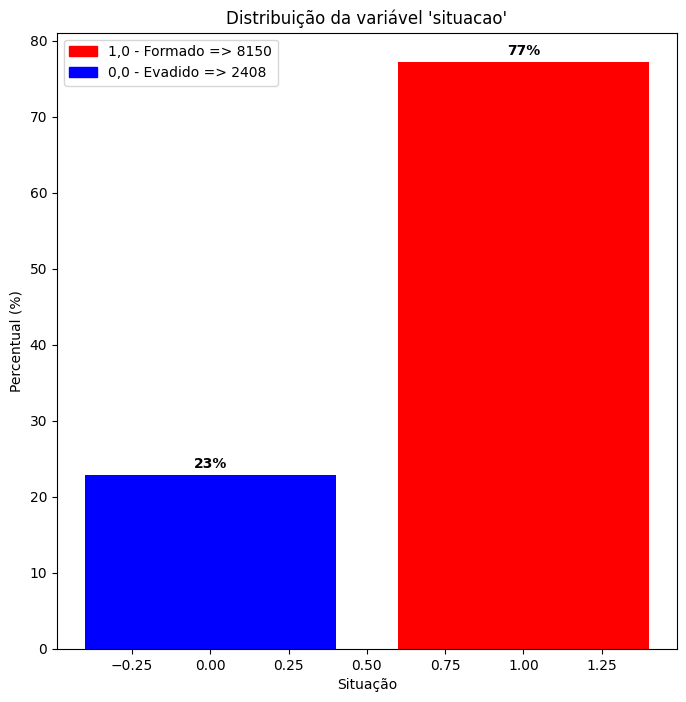

O dataset passará por uma sub-amostragem
Antes:  Counter({1: 8150, 0: 2408})
Depois:  Counter({0: 2408, 1: 2408})


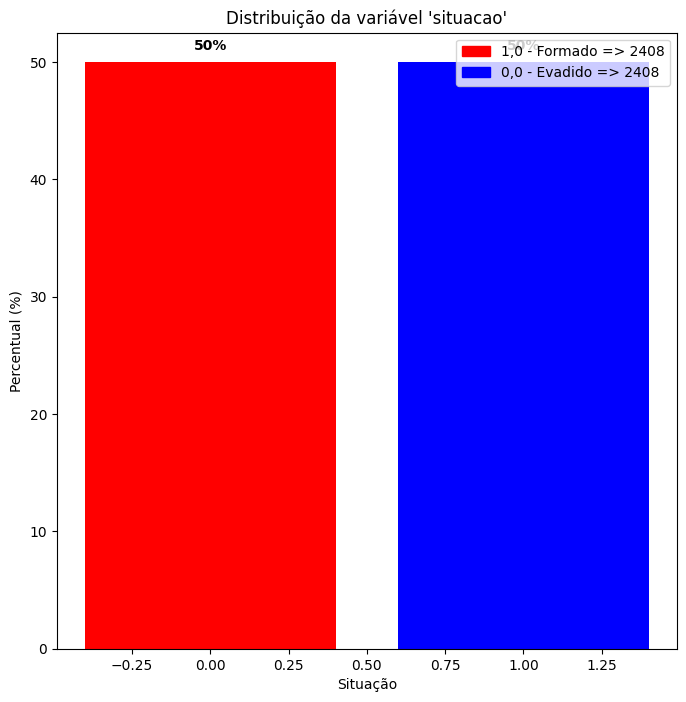


Análise de desbalanceamento do dataset de validação


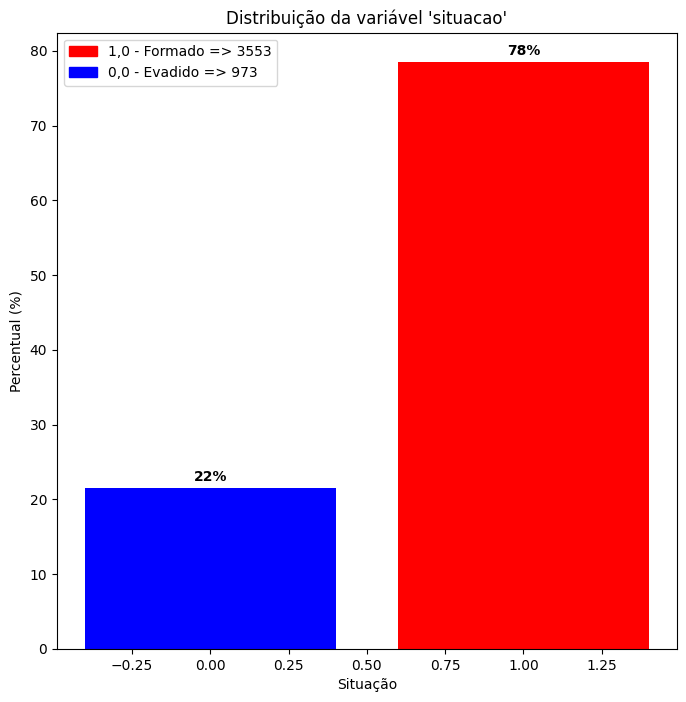

O dataset passará por uma sub-amostragem
Antes:  Counter({1: 3553, 0: 973})
Depois:  Counter({0: 973, 1: 973})


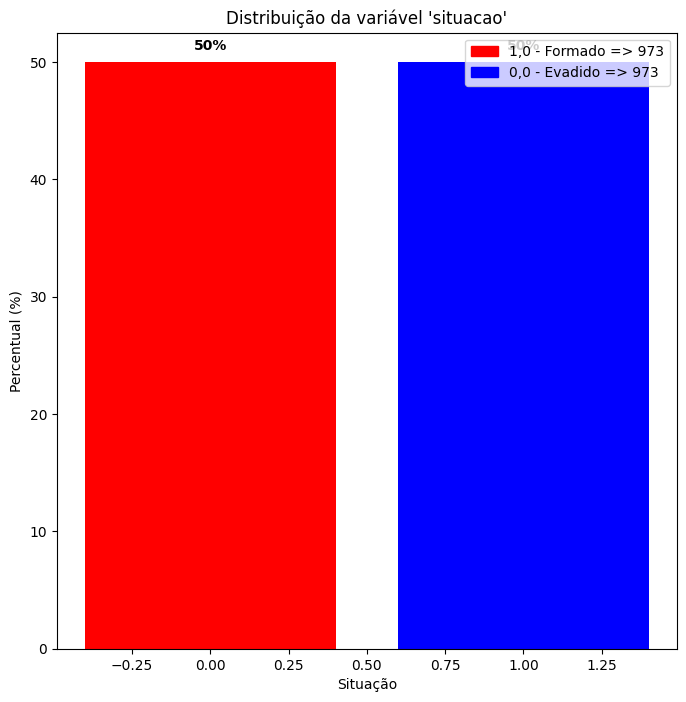

In [ ]:
if __name__ == '__main__':
    main()

##2. [Sel Att] => Variar Classificador => XAI

Vários Clasificadores: Paradigmas (SVM / KNN / RF / NB / etc ) => XAI

##3. Acc independente e XAI - a ver...

XAI: SHAPE e LIME

Sel Att -> Local